# Dynamics systems and prepare data

We have 2 type of systems, Lotka and Lorenz:


## Lorenz attractor originally used by [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) consists of three differential equations:

\begin{align*}
&\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma(y - x) + u_0,\\[1em]
&\frac{\mathrm{d}y}{\mathrm{d}t} = x(\rho - z) - y,\\[1em]
&\frac{\mathrm{d}z}{\mathrm{d}t} = xy - \beta z - u_1.
\end{align*}


## Voltera-Lotki equation is used to describe the dynamics of biological systems [Lotka–Volterra equations](https://en.wikipedia.org/wiki/Lotka-Volterra_equations) consists of two differential equations:

\begin{align*}
&\frac{\mathrm{d}x}{\mathrm{d}t} = ax - bxy,\\[1em]
&\frac{\mathrm{d}y}{\mathrm{d}t} = cxy - dy,\\[1em]
\end{align*}

with the following parameter values:
```python
a=1.0
b=0.3
c=0.2
d=1.0
```
and the initial value at time $t = 0$ with $x = 10$ and $y = 5$.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pydmd import DMD, DMDc
from pydmd.plotter import plot_eigs
from scipy.integrate import solve_ivp


np.random.seed(42)

In [ ]:
# TODO change the control laws
def u_fun(t):
    return np.column_stack([np.sin(2 * t), t**2])

def lorenz_control(t, x, u_fun, sigma=10, beta=2.66667, rho=28):
    u = u_fun(t)
    return [
        sigma * (x[1] - x[0]) + u[0, 0],
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2] - u[0, 1],
    ]

In [ ]:
# Lotka model with control 

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

a=1.0
b=0.3
c=0.2
d=1.0


# Volter-Lotka model
def ode_Voltera_Lotka(t, xy, uu):
    x, y = xy
    dx_dt = a * x - b * x * y
    dy_dt = c * x * y - d * y + uu
    return [dx_dt, dy_dt]

def SciPy_VL(t_begin, t_end, x_init, y_init, t_space, u_con=None):
    # Interpolate control input if provided
    if u_con is not None:
        u_interp = scipy.interpolate.interp1d(t_space, u_con, bounds_error=False, fill_value="extrapolate")
        def ode_fun(t, xy):
            return ode_Voltera_Lotka(t, xy, u_interp(t))
    else:
        def ode_fun(t, xy):
            return ode_Voltera_Lotka(t, xy, 0.0)
    num_sol = solve_ivp(ode_fun, [t_begin, t_end], [x_init, y_init], **integrator_keywords, t_eval=t_space)
    return num_sol.y[0], num_sol.y[1]

t_init = 0
t_end = 30
delta_t = 0.003
x_init = 10
y_init = 5
N_t = int((t_end-t_init) / delta_t)
t_array = np.linspace(t_init, t_end, 1 + N_t)

# Control input u(t)
u_con = (2 * np.sin(t_array) * np.sin(t_array / 10)) ** 2

x_solved, y_solved = SciPy_VL(t_begin=t_init, t_end=t_end, x_init=x_init, y_init=y_init, t_space=t_array, u_con=u_con)

In [ ]:
#Define training dataset to use for model construction
N_train = int(N_t*0.8)

x_train = x_solved[:N_train]
y_train = y_solved[:N_train]
t_train = t_array[:N_train]

In [ ]:
#Plot training and testing datasets
plt.figure(figsize=(14, 6))
plt.plot(t_train, x_train, linewidth=1, label='$x$ train')
plt.plot(t_train, y_train, linewidth=1, label='$x$ train')
plt.plot(t_array[N_train:], x_solved[N_train:], '--', linewidth=1, label='$x$ test')
plt.plot(t_array[N_train:], y_solved[N_train:], '--', linewidth=1, label='$y$ test')
plt.title('Volter-Lotka ODEs')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [ ]:
state_dim = 2
u_dim = 1

def Improved_DMDc(X_data: np.ndarray, U_control: np.ndarray, rank_p: int, rank_r: int):
    # construct snapshot
    X = X_data[:, :-1]  # current time k
    Y = X_data[:, 1:]   # next time k+1

    # the shape of U is: 3 x Number of time stamp
     
    # Augmented data matrix
    print("the shape of X is: ", X.shape)
    print("the shape of U_control is: ", U_control.shape)
    assert X.shape[1] == U_control.shape[1], "X_data and U_control must have the same number of time steps."
    Omega = np.vstack((X, U_control))

    # 2 perform SVD for Omega
    UU, SS, VVt = np.linalg.svd(Omega, full_matrices=False)

    print("the shape of UU is: ", UU.shape)
    print("the shape of SS is: ", SS.shape)
    print("the shape of VVt is: ", VVt.shape)
    # truncation
    rank_p = min(rank_p, len(SS))
    # U_tilde = UU[:, rank_p]
    U_tilde_state = UU[:state_dim, rank_p]
    U_tilde_col = UU[state_dim:, rank_p]
    S_tilde = SS[:rank_p]
    Vh_tilde = VVt[:rank_p, :].T

    # # construct pseudo inverse
    # gamma1 = Vh_tilde @ np.linalg.inv(S_tilde) @ U_tilde_state
    # TODO: can we perform truncated SVD for gamma2???
    gamma2 = Vh_tilde @ np.linalg.inv(S_tilde) @ U_tilde_col

    # 3 perform SVD for submatrix H
    UU_h, SS_h, VVt_h = np.linalg.svd(np.linalg.inv(np.diag(S_tilde)) @ U_tilde_state, full_matrices=False)

    gamma1 = U_tilde_state @ UU_h[:, :rank_r] @ np.diag(SS_h[:rank_r]) @ VVt_h[:rank_r, :]

    # 4 reduced approximations of A and B (do the projection on row space of matrix A)
    P_v = VVt_h[:rank_r, :].T
    A_tilta = P_v.T @ Y @ U_tilde_state @ UU_h[:, :rank_r] @ np.diag(SS_h[:rank_r])
    B_tilta = P_v.T @ Y @ gamma2

    # 5 eigen decomposition for reduced transition matrix A_tilta to find eigen value of orginal A
    Lamda_a, W_a = np.linalg.eig(A_tilta)

    # 6 compute DMD mode (eigenvector of original matrix A)
    Phi = Y @ U_tilde_state @ UU_h[:, :rank_r] @ np.diag(SS_h[:rank_r]) @ W_a

    # reconstruction in reduced order model
    Y_tilta_recons = A_tilta @ (P_v.T @ X) + B_tilta @ U_control
    # map back to original coordinate
    Y_dmd_recons = P_v @ Y_tilta_recons     

    return Lamda_a, Phi, Y_dmd_recons

In [ ]:
X_data = np.vstack((x_solved, y_solved))
# new dmdc
Lamda_a, Phi, Y_dmd_recons = Improved_DMDc_new(X_data=X_data, U_control=u_con.reshape(1, -1)[:, :-1], rank_p=10, rank_r=5)

# # # old dmdc
# Lamda_a_old, Phi_old, Y_dmd_recons_old = Improved_DMDc(X_data=X_data, U_control=u_con.reshape(1, -1)[:, :-1], rank_p=10, rank_r=5)




In [28]:
import numpy as np

def Improved_DMDc_new(X_data: np.ndarray, U_control: np.ndarray, rank_p: int, rank_r: int):
    """
    Compute Improved Dynamic Mode Decomposition with Control (Improved DMDc).

    Parameters:
    - X_data: ndarray of shape (state_dim, num_time_steps)
              Time series data of states.
    - U_control: ndarray of shape (u_dim, num_time_steps)
                 Time series data of control inputs.
    - rank_p: int
              Truncation rank for SVD of Omega.
    - rank_r: int
              Truncation rank for SVD of H.

    Returns:
    - Lamda_a: ndarray
               Eigenvalues of the reduced transition matrix A.
    - Phi: ndarray
           DMD modes.
    - Y_dmd_recons: ndarray
                    Reconstructed future states using DMDc.
    - bar_A: ndarray
             Reduced system matrix A.
    - bar_B: ndarray
             Reduced input matrix B.
    - bar_V: ndarray
             Projection matrix for reduced space.
    """
    # Step 1: Get dimensions
    state_dim, num_time_steps = X_data.shape
    u_dim, _ = U_control.shape
    assert num_time_steps == U_control.shape[1] + 1, "X_data and U_control must have the same number of time steps."

    # Step 2: Construct snapshot matrices
    X = X_data[:, :-1]  # Current states (time k)
    Y = X_data[:, 1:]   # Future states (time k+1)
    Gamma = U_control  # Control inputs aligned with X

    # Step 3: Augmented data matrix
    Omega = np.vstack((X, Gamma))

    # Step 4: Perform SVD for Omega
    UU, SS, VVt = np.linalg.svd(Omega, full_matrices=False)

    # Step 5: Truncate SVD components
    p = min(rank_p, len(SS))
    U_p = UU[:, :p]
    S_p = SS[:p]
    V_p = VVt.T[:, :p]  # V from SVD

    # Step 6: Split U_p into state and control parts
    U1_p = U_p[:state_dim, :]  # State part
    U2_p = U_p[state_dim:, :]  # Control part

    # Step 7: Compute H for Improved DMDc
    if p > 0:
        inv_S_p = np.linalg.inv(np.diag(S_p))
        H = inv_S_p @ U1_p.T  # H = Sigma^{-1} * U1^T
    else:
        raise ValueError("Truncation rank p must be greater than 0.")

    # Step 8: SVD of H
    Uh, Sh, Vth = np.linalg.svd(H, full_matrices=False)
    r = min(rank_r, len(Sh))
    Uh_r = Uh[:, :r]
    Sh_r = Sh[:r]
    bar_V = Vth.T[:, :r]  # bar_V = V_h

    # Step 9: Compute bar_U
    bar_U = V_p @ Uh_r  # V_p is m x p, Uh_r is p x r -> m x r

    # Step 10: Compute reduced approximations of A and B
    bar_A = bar_V.T @ Y @ bar_U @ np.diag(Sh_r)
    Omega_2 = V_p @ inv_S_p @ U2_p.T  # m x p @ p x p @ p x u_dim -> m x u_dim
    bar_B = bar_V.T @ Y @ Omega_2  # r x n @ n x m @ m x u_dim -> r x u_dim

    # Step 11: Eigen decomposition of bar_A
    Lamda_a, W_a = np.linalg.eig(bar_A)

    # Step 12: Compute DMD modes
    Phi = Y @ bar_U @ np.diag(Sh_r) @ W_a  # n x m @ m x r @ r x r @ r x r -> n x r

    # Step 13: Reconstruction
    z_k = bar_V.T @ X  # Reduced states z_k = bar_V^T * X
    Y_tilta_recons = bar_A @ z_k + bar_B @ Gamma  # r x r @ r x (T-1) + r x u_dim @ u_dim x (T-1)
    Y_dmd_recons = bar_V @ Y_tilta_recons  # n x r @ r x (T-1) -> n x (T-1)
    print("the shape of bar_V inside dmdc is: ", bar_V.shape)
    return Lamda_a, Phi, Y_dmd_recons, bar_A, bar_B, bar_V

the shape of bar_V inside dmdc is:  (2, 2)


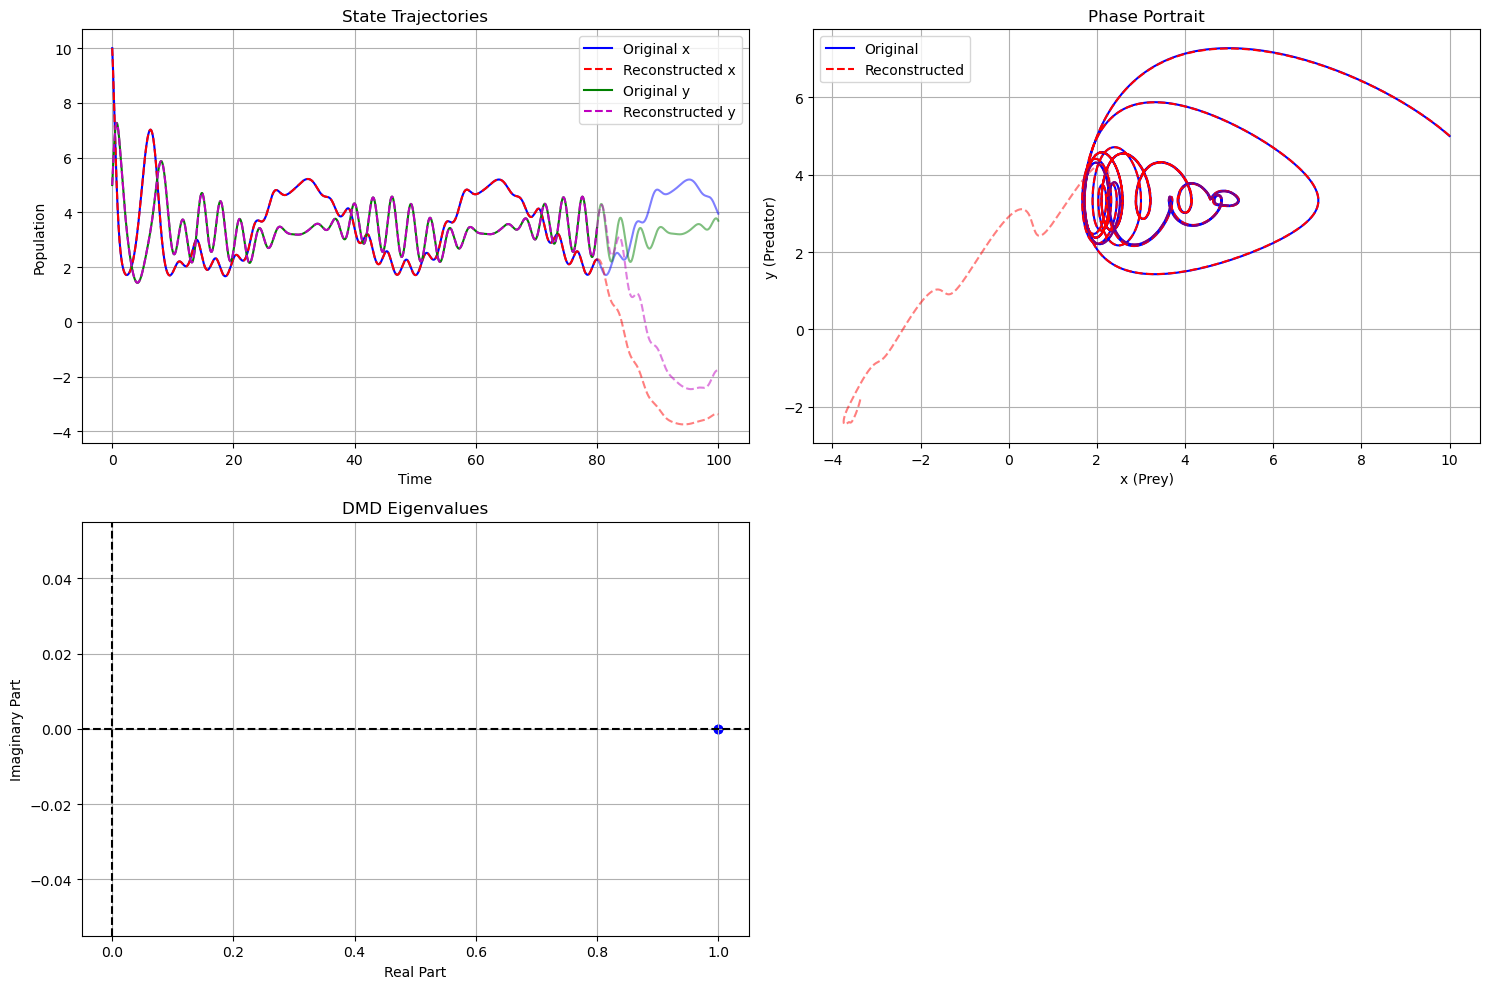

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.interpolate

# Lotka-Volterra parameters
a, b, c, d = 1.0, 0.3, 0.2, 1.0
integrator_keywords = {'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}

# Volterra-Lotka ODE
def ode_Volterra_Lotka(t, xy, uu):
    x, y = xy
    dx_dt = a * x - b * x * y
    dy_dt = c * x * y - d * y + uu
    return [dx_dt, dy_dt]

# Simulation function
def SciPy_VL(t_begin, t_end, x_init, y_init, t_space, u_con=None):
    if u_con is not None:
        u_interp = scipy.interpolate.interp1d(t_space, u_con, bounds_error=False, fill_value="extrapolate")
        def ode_fun(t, xy):
            return ode_Volterra_Lotka(t, xy, u_interp(t))
    else:
        def ode_fun(t, xy):
            return ode_Volterra_Lotka(t, xy, 0.0)
    num_sol = solve_ivp(ode_fun, [t_begin, t_end], [x_init, y_init], **integrator_keywords, t_eval=t_space)
    return num_sol.y[0], num_sol.y[1]

# Simulation parameters
t_init, t_end, delta_t = 0, 100, 0.003
x_init, y_init = 10, 5
N_t = int((t_end - t_init) / delta_t) + 1
t_array = np.linspace(t_init, t_end, N_t)
u_con = (2 * np.sin(t_array) * np.sin(t_array / 10)) ** 2
x_solved, y_solved = SciPy_VL(t_begin=t_init, t_end=t_end, x_init=x_init, y_init=y_init, t_space=t_array, u_con=u_con)

# Training data
N_train = int(N_t * 0.8)
x_train = x_solved[:N_train]
y_train = y_solved[:N_train]
t_train = t_array[:N_train]
X_data = np.vstack((x_train, y_train))
U_control = u_con[:N_train-1].reshape(1, -1)

# Apply Improved DMDc
rank_p, rank_r = 20, 10
eigenvalues, modes, recons, bar_A, bar_B, bar_V = Improved_DMDc_new(X_data, U_control, rank_p, rank_r)

# Predict future states
X_data_test = np.vstack((x_solved[N_train], y_solved[N_train]))
z_k = bar_V.T @ X_data_test  # Reduced initial states
future_steps = N_t - N_train
Y_pred = np.zeros((2, future_steps))

z_current = z_k[:,0].reshape(-1, 1)  # Initial reduced state

for i in range(future_steps):
    u_current = u_con[N_train + i].reshape(1, -1)
    z_next = bar_A @ z_current + bar_B @ u_current
    Y_pred[:, i] = (bar_V @ z_next).reshape(2,)
    z_current = z_next

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: State trajectories
plt.subplot(2, 2, 1)
plt.plot(t_array[:N_train-1], X_data[0, :-1], 'b-', label='Original x')
plt.plot(t_array[:N_train-1], recons[0, :], 'r--', label='Reconstructed x')
plt.plot(t_array[:N_train-1], X_data[1, :-1], 'g-', label='Original y')
plt.plot(t_array[:N_train-1], recons[1, :], 'm--', label='Reconstructed y')
plt.plot(t_array[N_train:], x_solved[N_train:], 'b-', alpha=0.5)
plt.plot(t_array[N_train:], y_solved[N_train:], 'g-', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred[0, :], 'r--', alpha=0.5)
plt.plot(t_array[N_train:], Y_pred[1, :], 'm--', alpha=0.5)
plt.title('State Trajectories')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

# Plot 2: Phase portrait
plt.subplot(2, 2, 2)
plt.plot(X_data[0, :-1], X_data[1, :-1], 'b-', label='Original')
plt.plot(recons[0, :], recons[1, :], 'r--', label='Reconstructed')
plt.plot(x_solved[N_train-1:], y_solved[N_train-1:], 'b-', alpha=0.5)
plt.plot(Y_pred[0, :], Y_pred[1, :], 'r--', alpha=0.5)
plt.title('Phase Portrait')
plt.xlabel('x (Prey)')
plt.ylabel('y (Predator)')
plt.legend()
plt.grid(True)

# Plot 3: Eigenvalues
plt.subplot(2, 2, 3)
plt.scatter(eigenvalues.real, eigenvalues.imag, c='b', marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.title('DMD Eigenvalues')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)

# # Plot 4: DMD Modes
# plt.subplot(2, 2, 4)
# for i in range(modes.shape[1]):
#     plt.bar([i-0.2, i+0.2], [modes[0, i].real, modes[1, i].real], width=0.4, label=f'Mode {i+1} Real')
# plt.title('DMD Modes (Real Part)')
# plt.xlabel('Mode Index')
# plt.ylabel('Mode Amplitude')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
# plt.savefig('lotka_volterra_dmdc_analysis.png')
# plt.close()

plt.show()

In [42]:
print(  "Eigenvalues of the reduced system matrix A:", eigenvalues)
print("DMD Modes shape: \n", modes)

Eigenvalues of the reduced system matrix A: [0.99927646+0.0009213j 0.99927646-0.0009213j]
DMD Modes shape: 
 [[-0.65808287-0.21478456j -0.65808287+0.21478456j]
 [-0.68594561+0.22096932j -0.68594561-0.22096932j]]


In [ ]:
from pydmd import DMD, DMDc
from pydmd.plotter import plot_eigs
#Compute DMDc using the corresponding classes in PyDMD package

dmdc = DMDc(svd_rank=-1)
dmdc.fit(X_data, U_control)
# plot_eigs(dmdc)
print("DMDc Eigenvalues:", dmdc.eigs)
print("DMDc Modes shape: \n", dmdc.modes)



DMDc Eigenvalues: [0.99927646+0.0009213j 0.99927646-0.0009213j]
DMDc Modes shape: 
 [[-0.65336407-0.22873756j -0.65336407+0.22873756j]
 [-0.69049177+0.20632486j -0.69049177-0.20632486j]]
